# 50 - Experiment 2: figures and tables

In [1]:
from pathlib import Path

# PATHS
METRICS_DIR = Path("45-experiment_2_metrics").resolve() # Or set the path to the metrics extracted from the release archive
METRICS_DIR

PosixPath('/home/bertrand/dev/paper-ner-bench-das22/src/ner/45-experiment_2_metrics')

In [2]:
import os, re

import pandas as pd
import matplotlib.pyplot as plt

metrics_jsons = [f for f in os.listdir(METRICS_DIR) if ".json" in f]
camembert_pretrained_finetuned_on_ref = [f for f in metrics_jsons if "camembert_pretrained_ref" in f]
camembert_finetuned_on_ref = [f for f in metrics_jsons if "camembert_ref" in f]
camembert_pretrained_finetuned_on_pero = [f for f in metrics_jsons if "camembert_pretrained_pero" in f]
camembert_finetuned_on_pero = [f for f in metrics_jsons if "camembert_pero" in f]

def json_list_as_dataframe(jsons_files, finetuned_on, model):  
    test_sets = [re.match(".+_(\w+)\.json",fn).group(1) for fn in jsons_files]
    df = pd.concat([pd.read_json(METRICS_DIR / fn, lines=True) for fn in jsons_files])
    df["tested_on"] = test_sets
    df["finetuned_on"] = finetuned_on
    df["model"] = model
    df.set_index(keys=["tested_on"], inplace=True)
    return df.loc[["ref","pero","tess"]] 

camembert_pretrained_finetuned_on_ref = json_list_as_dataframe(camembert_pretrained_finetuned_on_ref,"ref","camembert_pretrained")
camembert_pretrained_finetuned_on_pero = json_list_as_dataframe(camembert_pretrained_finetuned_on_pero,"pero","camembert_pretrained") 
camembert_finetuned_on_ref = json_list_as_dataframe(camembert_finetuned_on_ref,"ref","camembert")
camembert_finetuned_on_pero = json_list_as_dataframe(camembert_finetuned_on_pero,"pero","camembert")

Create the table to display as bar chart

In [9]:
# One group per test-set
# Keep only the F1-score
reshaped = pd.concat([camembert_finetuned_on_ref[["test_f1"]].rename(columns={"test_f1":"CmBERT$_{reference}$"}),
                      camembert_pretrained_finetuned_on_ref[["test_f1"]].rename(columns={"test_f1":"cmBERT+ptrn$_{reference}$"}),
                      camembert_finetuned_on_pero[["test_f1"]].rename(columns={"test_f1":"cmBERT$_{pero}$"}),
                      camembert_pretrained_finetuned_on_pero[["test_f1"]].rename(columns={"test_f1":"CmBERT+ptrn$_{pero}$"}),
              ], axis=1)
reshaped = reshaped.multiply(100., axis=1)
reshaped.rename(mapper={"ref":"reference", "tess":"tesseract"},axis=0, inplace=True)
reshaped

<Figure size 432x288 with 0 Axes>

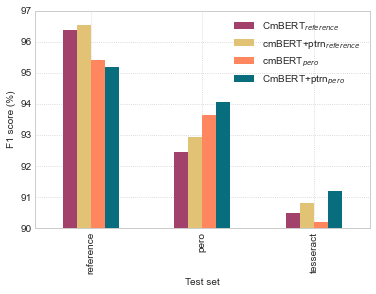

In [9]:
plt.style.use('seaborn-whitegrid')  # Nicer plots
# Uncomment if you want to use LaTeX fonts (on Linux, requires the packages dvipng & cm-super)
#plt.rcParams['text.usetex'] = True
#plt.rcParams.update({'font.size': 12, 'font.family': 'serif', 'font.serif': ['Computer Modern']})

# Plot the graph
plt.tight_layout()
fig = reshaped.plot.bar(color=["#A2416B","#E2C275","#FF865E","#086E7D"], xlabel="Test set",ylabel="F1 score (%)")
fig.grid(linestyle='dotted') 
fig.set_ylim([90, 97])
legend = plt.legend(loc="upper right")
plt.savefig('experiment_2_f1_with_noise_graph.pdf', dpi=300, format='pdf',bbox_inches='tight')

In [4]:

print(reshaped.to_latex(float_format="%.1f", multirow=True, caption="",escape = False))

\begin{tabular}{lrrrr}
\toprule
{} &  CmBERT$_{reference}$ &  cmBERT+ptrn$_{reference}$ &  cmBERT$_{pero-ocr}$ &  CmBERT+ptrn$_{pero-ocr}$ \\
tested_on &                       &                            &                      &                           \\
\midrule
reference &                  96.4 &                       96.5 &                 95.4 &                      95.2 \\
pero-ocr  &                  92.5 &                       92.9 &                 93.6 &                      94.1 \\
tesseract &                  90.5 &                       90.8 &                 90.2 &                      91.2 \\
\bottomrule
\end{tabular}

